In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from nbdev import *

In [ ]:
#default_exp inference

In [ ]:
#export
import ijson
import pkg_resources
import pandas as pd
from cytoolz import itertoolz
from tqdm.auto import tqdm

from fastcore.foundation import patch_to

In [ ]:
#export
from nnanno.core import *
from nnanno.sample import *

In [ ]:
#export
from typing import (
    Any,
    Optional,
    Union,
    Dict,
    List,
    Tuple,
    Set,
    Iterable,
)
from PIL import Image
import PIL

In [ ]:
#export 
import fastai
from fastai.vision.all import *
from fastcore import *

# Inference

This module contains some functionality for doing inference i.e. making predictions on new images from Newspaper Navigator. At the moment this functionality assumes that the model has been trained using the [fastai](https://docs.fast.ai/) library. 

This section of nnanno isn't intended to show 'the best' way of doing inference but to show one possible way in which we can pragmatically scale the amount of data we're able to work with without having to have extensive resources available.

## Notes on inference

The Newspaper Navigator data is split into different categories i.e. photos, maps, ads etc. Some of these are fairly large datasets if you were to work with the full collection. As a result of this making local copies of all of these images would require a lot of storage space to be available. Since we can access images via IIIF the `inference` module uses IIIF to access images for making predictions. This means that images can be loaded into memory to make predictions and the results of the predictions stored without having to also store the image. This won't always be an optimal approach in all cases and we need to be considerate in our requests to the IIIF server. 


### Training a model




Since we are going to use fastai for inference we'll quickly create a model that we can use to test inference functionality. 
This model is just intended to help develop the inference functionality so we won't worry about the performance of the model itself. 

In [ ]:
dls = ImageDataLoaders.from_csv('../ph/ads/', 'ads_upsampled.csv',folder='images', fn_col='file', label_col='label',
                                item_tfms=Resize(64,ResizeMethod.Squish),num_workers=0)

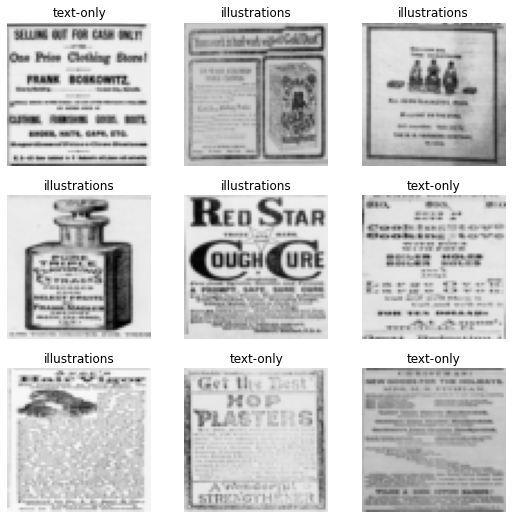

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=F1Score())
learn.fine_tune(1)

epoch,train_loss,valid_loss,f1_score,time
0,1.084256,0.696342,0.754491,00:12


epoch,train_loss,valid_loss,f1_score,time
0,0.492170,0.569242,0.777778,00:16


## Inference helpers 

The next few functions are 'helper' functions which are used for doing inference using the Newspaper Navigator data. 

### Missing images
Because we are dealing with images requested via the web we have to deal with the occasional hiccup. These hiccups could include requested image not being returned from an IIIF request, or a network issue etc. As a reminder of what `load_url_image` does

In [ ]:
doc(load_url_image)

load_url_image [source] load_url_image ( url : str , mode = 'RGB' ) 
 
 Attempts to load an image from url returns None if request times out or no image at url 
 Show in docs

As you can see above `load_url_image` will sometimes return `None`. When we're running inference this can cause an issue because we want to create batches of images to speed up inference. We don't want to include `None`s in a batch of images to predict since fastai/pytorch won't know what to do with it. 

To get around this we create a function which filters a batch of images and replaces `None` with a fake image. This function also returns the index of items which were originally `None`. We later use this index of items which were `None` to replace any predictions made for dummy images with `np.nan`

In [ ]:
#export
def _filter_replace_none_image(results:List[Optional[PIL.Image.Image]]):
    """
    filters a list containing images and `None`, replaces `None` with dummy images
    returns: original images and dummy images + a location index for the dummy images
    """
    fakeim = Image.fromarray(244 * np.ones((250,250,3), np.uint8))
    results = L(results)
    none_image_index = results.argwhere(lambda x: x is None) # Gets the index for images which are none
    results[none_image_index] = fakeim # Replaces None with fakeim
    return results.items, none_image_index

We use this function to deal with `None`s appearing in our image batches before we pass them to a fastai learner.

### Note
This could be a sub-optimal approach to this issue but since we don't encounter too many missing images and the overhead for this is fairly low it seems like an okay solution and allows us to still work in batches rather than working with a single image at a time. This is useful especially when we have a GPU available. 

### Notes on fastcore

You may have seen that the results in wrapped in `L`. This comes from `fastcore` and is a Class which adds some extra bells and whilsles to a standard Python list see the [fastcore docs](https://fastcore.fast.ai/foundation.html#L) for more details. In this case we can use it to grab the indexes of images which are `None`. Some other nice features include displaying nicely in notebooks 

In [ ]:
L([1,2,3,4])

(#4) [1,2,3,4]

We get a handy `#4` count to indicate the length of a sequence. This is surprisingly handy especially for someone who is lazy like me. 

In [ ]:
im_files = (get_image_files('../ph/ads/images'))[:8] 
results = list(map(PILImage.create,im_files))
results.append(None)
results = [None] + results
image_batch,none_image_index =_filter_replace_none_image(results)
assert len(results) == len(image_batch)
assert none_image_index.items == [0,9] # check indexes are at the start and end of list

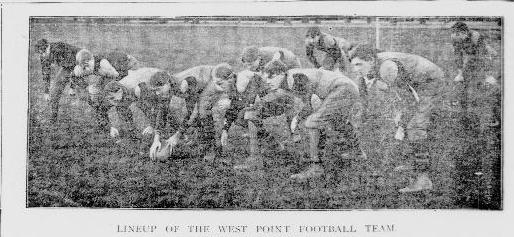

In [ ]:
#hide
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url);im

In [ ]:
#hide
im_files = (get_image_files('../ph/ads/images'))[:4]
images = list(map(PILImage.create, im_files))
results = [None] + images 
images,index =_filter_replace_none_image(results)

image_batch = [np.array(im) for im in images]
test_data = learn.dls.test_dl(image_batch)
pred_tuple = learn.get_preds(dl=test_data, with_decoded=True)
pred_decoded = L(pred_tuple[2], use_list=True)
pred_tensor =  L(pred_tuple[0],use_list=True)
pred_decoded[index] = np.nan; pred_tensor[index] = np.nan
pred_decoded.items, pred_tensor.items

([nan, tensor(1), tensor(1), tensor(1), tensor(0)],
 [nan,
  tensor([0.3228, 0.6772]),
  tensor([0.2402, 0.7598]),
  tensor([0.1294, 0.8706]),
  tensor([0.9820, 0.0180])])

In [ ]:
#hide
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url)
images = [im,im,im]
results = [None] + images 
images,index =_filter_replace_none_image(results)
image_batch = [np.array(im) for im in images]
list(map(np.shape,image_batch))

[(250, 250, 3), (237, 514, 3), (237, 514, 3), (237, 514, 3)]

This is a helper to create a header for the metadata from newspaper navigator 

In [ ]:
#exporti
def _create_pred_header(fname, dls=None):
    columns=[
            "filepath",
            "pub_date",
            "page_seq_num",
            "edition_seq_num",
            "batch",
            "lccn",
            "box",
            "score",
            "ocr",
            "place_of_publication",
            "geographic_coverage",
            "name",
            "publisher",
            "url",
            "page_url",
            "iiif_url",
            "pred_decoded"]
    if dls:
        columns += (list(dls.vocab))
    return pd.DataFrame(columns=columns).to_csv(fname, index=None)

In [ ]:
#hide
_create_pred_header('test_header.csv')
df = pd.read_csv('test_header.csv')
assert df.columns.to_list() == ['filepath', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch',
       'lccn', 'box', 'score', 'ocr', 'place_of_publication',
       'geographic_coverage', 'name', 'publisher', 'url', 'page_url',
       'iiif_url', 'pred_decoded']
Path('test_header.csv').unlink()
_create_pred_header('test_header.csv', dls=dls)
df = pd.read_csv('test_header.csv')
assert len(df[dls.vocab].columns) == dls.c
Path('test_header.csv').unlink()

In [ ]:
#exporti
def _create_year_csv(out_dir, year,kind,dls=None):
    fname = Path(f"{out_dir}/{year}_{kind}.csv")
    _create_pred_header(fname, dls)
    return fname

In [ ]:
#exporti
def _create_year_json(out_dir, year,kind, batch):
    return Path(f"{out_dir}/{year}_{kind}_{batch}.json")

In [ ]:
#hide
Path('test_csv').mkdir()
_create_year_csv('test_csv',1850,'ads')
assert Path('test_csv/1850_ads.csv').exists() == True
Path('test_csv/1850_ads.csv').unlink();Path('test_csv/').rmdir()

In [ ]:
#exporti
def _make_directory(directory, force=False):
    if not force:
        if Path(directory).exists() and len(list(os.scandir(directory))) >=1:
            raise ValueError(f'{directory} already exists and is not empty')
    Path(directory).mkdir(exist_ok=True,parents=True)

In [ ]:
#hide
_make_directory('test_dir')
assert Path('test_dir/').exists() ; Path('test_dir/test.file').touch()
with ExceptionExpected(ex=ValueError, regex="test_dir already exists and is not empty"): 
    _make_directory('test_dir')
Path('test_dir/test.file').unlink(); Path('test_dir').rmdir()

## Predict

Below is the main code for doing the inference. [`patch_to`](https://fastcore.fast.ai/basics.html#patch_to) is used to add new methods to the `nnPredict` class. This is helpful for avoiding one massive code cell in a Jupyter notebook. Like other aspects of `nnanno` this approach is probably upsetting. 

In [ ]:
# TODO add predict for multilabels 
# check for multicategory tensor
# tensor preds can be passed directly to DF?

In [ ]:
#exports
class nnPredict:
    """`nnPredict` is used in combination with a trained leaner to run inference on Newspaper Navigator"""
    population = pd.read_csv(pkg_resources.resource_stream('nnanno', 'data/all_year_counts.csv'), index_col=0)
    def __init__(self, learner:fastai.learner, try_gpu:bool=True):
        """Creates an ``nnPredict` instance from `learner`, puts on GPU if `try_gpu` is true and CUDA is avilable"""
        self.learner = learner
        self.try_gpu = try_gpu
        self.dls = learner.dls
        self.decode_map = {v: k for v, k in enumerate(self.learner.dls.vocab)}

    def __repr__(self):
        return (f'{self.__class__.__name__} \n'
               f'learner vocab:{self.learner.dls.vocab}')

In [ ]:
show_doc(nnPredict)

<h2 id="nnPredict" class="doc_header"><code>class</code> <code>nnPredict</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>nnPredict</code>(**`learner`**:`fastai.learner`, **`try_gpu`**:`bool`=*`True`*)

[`nnPredict`](/nnanno/inference.html#nnPredict) is used in combination with a trained leaner to run inference on Newspaper Navigator

`nnPredict` is a class used to do the predictions. It takes as input a `fastai` `learner` and a boolean option which controls whether the prediction methods should try and make use of a GPU or not. 

## more helpers

A few more helper methods 

In [ ]:
#export
@patch_to(nnPredict, cls_method=True)
def _get_year_population_size(cls, kind:str,year:Union[str,int]):
        return cls.population[f"{kind}_count"][year]

In [ ]:
#export
@patch_to(nnPredict, cls_method=True)
def _get_year_sample_size(cls, kind: str, year: Union[str,int],sample_size):
    return (cls._get_year_population_size(kind, year) * sample_size).clip(1).round()

In [ ]:
#export
@patch_to(nnPredict)
def predict_from_sample_df(self, sample_df:pd.DataFrame, bs: int = 16,
                           disable_pbar:bool=False) -> pd.DataFrame:
    """
    Runs inference on `sample_df` using batch size `bs`, `disable_pbar` controls whether to show progress bar
    Returns a Pandas DataFrame containing orginal dataframe and predictions, with labels taken from `learner.dls.vocab`
    """
    self.sample_df = sample_df
    gpu = False
    if self.try_gpu and torch.cuda.is_available():
        gpu = True
    if gpu:
        self.learner.model = self.learner.model.cuda()

    self.sample_df['iiif_url'] = self.sample_df.apply(lambda x: iiif_df_apply(x), axis=1)
    dfs = []

    splits = max(1,round(len(self.sample_df)/bs))
    for df in tqdm(np.array_split(sample_df, splits),
                   disable=disable_pbar,
                   leave=False,
                   desc='Batch progress'):
        futures = []
        for url in df['iiif_url'].to_list():
            with concurrent.futures.ThreadPoolExecutor(4) as e:
                future = e.submit(load_url_image, url)
                futures.append(future)
        results = [future.result() for future in futures]
        image_list, none_index = _filter_replace_none_image(results)
        im_as_arrays = [np.array(image) for image in image_list]
       # if len(none_index) >0:
        #            tqdm.write(f"{none_index} skipped")
        test_data = self.learner.dls.test_dl(im_as_arrays)
        if gpu:
            test_data.to('cuda')
        with self.learner.no_bar():
            pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
            print(type(pred_tuple[2]))
        pred_decoded = L(pred_tuple[2], use_list=True)
        pred_tensor =  L(pred_tuple[0],use_list=None)
        pred_decoded[none_index] = np.nan
        pred_tensor[none_index] = np.nan
        df["pred_decoded"] = pred_decoded.items
        df["pred_decoded"] = df['pred_decoded'].astype(float)
        # create an empty df column for each class in dls.vocab
        for c in self.dls.vocab:
            df[f'{c}_prob'] = ''
        # append the tensor predictions to the last `c` colomns of the df
        df.iloc[:,-self.dls.c:] = np.hsplit(pred_tensor.items.numpy(), self.dls.c) #split into columns
        
        dfs.append(df)
    df = pd.concat(dfs)
    df['pred_decoded'] = df['pred_decoded'].map(self.decode_map)
    return df

In [ ]:
show_doc(nnPredict.predict_from_sample_df)

<h4 id="nnPredict.predict_from_sample_df" class="doc_header"><code>nnPredict.predict_from_sample_df</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_from_sample_df</code>(**`sample_df`**:`DataFrame`, **`bs`**:`int`=*`16`*, **`disable_pbar`**:`bool`=*`False`*)

Runs inference on `sample_df` using batch size `bs`, `disable_pbar` controls whether to show progress bar
Returns a Pandas DataFrame containing orginal dataframe and predictions, with labels taken from `learner.dls.vocab`

Most of the time it is likely we'll use the `predict_from_sample_df` as part of `predict_sample` 

In [ ]:
#export
@patch_to(nnPredict)
def predict_sample(self,
    kind: str,
    out_dir: str,
    sample_size: Union[int, float],
    bs: int = 16,
    start_year: int = 1850,
    end_year: int = 1950,
    step: int = 1,
    year_sample:bool=True,
    size=None,
    force_dir=False):
    _make_directory(out_dir,force_dir)
    years = range(start_year, end_year + 1, step)
    if type(sample_size) == float:
        total = int(self._get_year_sample_size(kind, list(years), sample_size).sum())
    if type(sample_size) == int:
        total = sample_size * len(years)
    dfs = []
    with tqdm(total=total) as pbar:
        for year in years:
            pbar.set_description(f"Predicting: {year}, total progress")
            sample = sample_year(kind, sample_size, year)
            sample_df = pd.DataFrame.from_records(sample)
            disable_pbar = False
            if len(sample_df) <= 2:
                disable_pbar = True
            pred_df = self.predict_from_sample_df(sample_df, bs, disable_pbar=disable_pbar)
            pred_df.to_json(f'{out_dir}/{year}.json') # TODO make sure this file is created before attempting to save
            pbar.update(len(pred_df))

In [ ]:
show_doc(nnPredict.predict_sample)

<h4 id="nnPredict.predict_sample" class="doc_header"><code>nnPredict.predict_sample</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_sample</code>(**`kind`**:`str`, **`out_dir`**:`str`, **`sample_size`**:`Union`\[`int`, `float`\], **`bs`**:`int`=*`16`*, **`start_year`**:`int`=*`1850`*, **`end_year`**:`int`=*`1950`*, **`step`**:`int`=*`1`*, **`year_sample`**:`bool`=*`True`*, **`size`**=*`None`*, **`force_dir`**=*`False`*)



`predict_sample` can be used to make predictions on new samples of the newspaper navigator dataset. The sampling works in mostly the same manner as in `create_sample`. The main difference is that we might want to also specify some changes to how images are requested via IIIF. For example if our model was trained on images of 256*256 we probably want to also use this size in our inference. 

Using the model trained at the top, we can pass our fastai learner into nnPredict. 

In [ ]:
pred = nnPredict(learn)

We now have created an ``nnPredict` inference object we can use to make predictions against newspaper navigator data. 

In [ ]:
pred

nnPredict 
learner vocab:['illustrations', 'text-only']

We can use `precit_sample` to run inference given some parameters. We should be considerate here about how large we make thios sample. In this case we are running against ads which is a particularly large dataset. We can either pass in a defined sample size for each year or we may want to have a percentage so we get a reprenstative sample for each year. In this case we just run a small sample as an example. 

In [ ]:
pred.predict_sample('ads','test/',0.001,start_year=1850, end_year=1852, bs=32, force_dir=True, size=(64,64))

<class 'torch.Tensor'>


<class 'torch.Tensor'>


<class 'torch.Tensor'>



When `predict_sample` is called a directory is created and a JSON file containing the predictions for each years sample is created. Let's load these predictions                                                                                                 

In [ ]:
df = pd.concat([pd.read_json(f) for f in (Path('test').rglob('*json'))])

If we take a look at the columns of the DataFrame we'll see some new columns

In [ ]:
df.columns

Index(['filepath', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch',
       'lccn', 'box', 'score', 'ocr', 'place_of_publication',
       'geographic_coverage', 'name', 'publisher', 'url', 'page_url',
       'iiif_url', 'pred_decoded', 'illustrations_prob', 'text-only_prob'],
      dtype='object')

`pred_decoded` contains the labels for your classes. 

In [ ]:
df['pred_decoded'].value_counts()

text-only        15
illustrations    13
Name: pred_decoded, dtype: int64

In [ ]:
#hide 
[f.unlink() for f in Path('test').iterdir()]; Path('test').rmdir()

In [ ]:
#df = pd.read_csv('../ph/photos/multi_label.csv', na_filter=False)
# df.columns

In [ ]:
# dls = ImageDataLoaders.from_df(df,folder='../ph/photos/images',
#                                fn_col='file', label_col='label',
#                                item_tfms=Resize(64),num_workers=0, 
#                            label_delim='|')

In [ ]:
# learn = cnn_learner(dls, resnet18)

In [ ]:
#learn.dls.vocab

In [ ]:
#p = learn.get_preds(with_decoded=True)

In [ ]:
#export
@patch_to(nnPredict)
def predict(
    self,
    kind: str,
    out_dir: str,
    bs: int = 32,
    start_year: int = 1850,
    end_year: int = 1950,
    step: int = 1,
    size=None
):
    _make_directory(out_dir)
    gpu = False
    if self.try_gpu and torch.cuda.is_available():
        gpu = True
    if gpu:
        self.learner.model = self.learner.model.cuda()
    years = range(start_year, end_year + 1, step)
    total = self._get_year_population_size(kind,years).sum()
    with tqdm(total=total) as pbar:
        for year in years:
            out_fn = _create_year_csv(out_dir,year,kind, self.learner.dls)
            pbar.set_description(f"Predicting: {year}, total progress")
            if kind == ('ads' and int(year) >=1870) or (kind == 'headlines'):
                s = create_session()
            else:
                s = create_cached_session()
            with s.get(get_json_url(year, kind), timeout=60) as r:
                data = ijson.items(r.content, "item")
                batches = itertoolz.partition_all(bs, iter(data))
                year_total = self._get_year_population_size(kind,year)
                if (year_total//bs) <= 1:
                    disable_p_bar = True
                for i, batch in enumerate(tqdm(batches,total=round(year_total//bs),
                                               leave=False,
                                               desc='Batch Progress')):
                    df = pd.DataFrame(batch)
                    df["iiif_url"] = df.apply(lambda x: iiif_df_apply(x), axis=1)
                    futures = []
                    workers = get_max_workers(df)
                    for iif_url in df["iiif_url"].values:
                        with concurrent.futures.ThreadPoolExecutor(workers) as e:
                            future = e.submit(load_url_image, iif_url)
                            futures.append(future)
                    results = [future.result() for future in futures]
                    image_list, none_index = _filter_replace_none_image(results)
                    im_as_arrays = [np.array(image) for image in image_list]
                    if len(none_index) >0:
                        tqdm.write(f"{none_index} skipped")
                    else:
                        pass
                    test_data = self.learner.dls.test_dl(im_as_arrays)
                    with self.learner.no_bar():
                        pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
                    pred_decoded = L(pred_tuple[2], use_list=True)
                    pred_tensor =  L(pred_tuple[0],use_list=None)
                    pred_decoded[none_index] = np.nan
                    pred_tensor[none_index] = np.nan
                    df["pred_decoded"] = pred_decoded.items
                    df["pred_decoded"] = df['pred_decoded'].astype(float)
                    #df['pred_decoded'].map({v: k for v, k in enumerate(self.learner.dls.vocab)}) 
                    # create an empty df column for each class in dls.vocab
                    for c in self.dls.vocab:
                        df[f'{c}_prob'] = ''
                    # append the tensor predictions to the last `c` columns of the df
                    df.iloc[:,-self.dls.c:] = np.hsplit(pred_tensor.numpy(),self.dls.c) #split into columns
                    df.to_csv(out_fn, header=None, index=None, mode="a")
                    pbar.update(bs)

In [ ]:
pred = nnPredict(learn)

In [ ]:
#pred.predict_sample('ads','testspeed/',0.001,start_year=1850, end_year=1852, bs=32,force_dir=True)

In [ ]:
show_doc(nnPredict.predict_sample)

<h4 id="nnPredict.predict_sample" class="doc_header"><code>nnPredict.predict_sample</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_sample</code>(**`kind`**:`str`, **`out_dir`**:`str`, **`sample_size`**:`Union`\[`int`, `float`\], **`bs`**:`int`=*`16`*, **`start_year`**:`int`=*`1850`*, **`end_year`**:`int`=*`1950`*, **`step`**:`int`=*`1`*, **`year_sample`**:`bool`=*`True`*, **`size`**=*`None`*, **`force_dir`**=*`False`*)



Newspaper Navigator can get quit big, for particular classes of visual content and certain years. Just as you may sample to create annotations if you are running inference you may also want to do this on a sample of the full data. The `predict_sample` method will run inference across a given type of image `kind`, creating a `sample_size` for each year between `start_year` and `end_year` for step size `step`.

`sample_size` can either be an int i.e. 100 predictions for each year, or it can be a float representing a percentage to sample from each year i.e. 10% from each year. 

### Limitations 
Currently `predict_sample` assumes that the size of each years sample can fit into memory. 


In [ ]:
#hide_input
show_doc(nnPredict.predict_from_sample_df)

<h4 id="nnPredict.predict_from_sample_df" class="doc_header"><code>nnPredict.predict_from_sample_df</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_from_sample_df</code>(**`sample_df`**:`DataFrame`, **`bs`**:`int`=*`16`*, **`disable_pbar`**:`bool`=*`False`*)

Runs inference on `sample_df` using batch size `bs`, `disable_pbar` controls whether to show progress bar
Returns a Pandas DataFrame containing orginal dataframe and predictions, with labels taken from `learner.dls.vocab`

In [ ]:
show_doc(nnPredict.predict)

<h4 id="nnPredict.predict" class="doc_header"><code>nnPredict.predict</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict</code>(**`kind`**:`str`, **`out_dir`**:`str`, **`bs`**:`int`=*`32`*, **`start_year`**:`int`=*`1850`*, **`end_year`**:`int`=*`1950`*, **`step`**:`int`=*`1`*, **`size`**=*`None`*)



In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
